## Camera calibration matrix and distortion coefficients

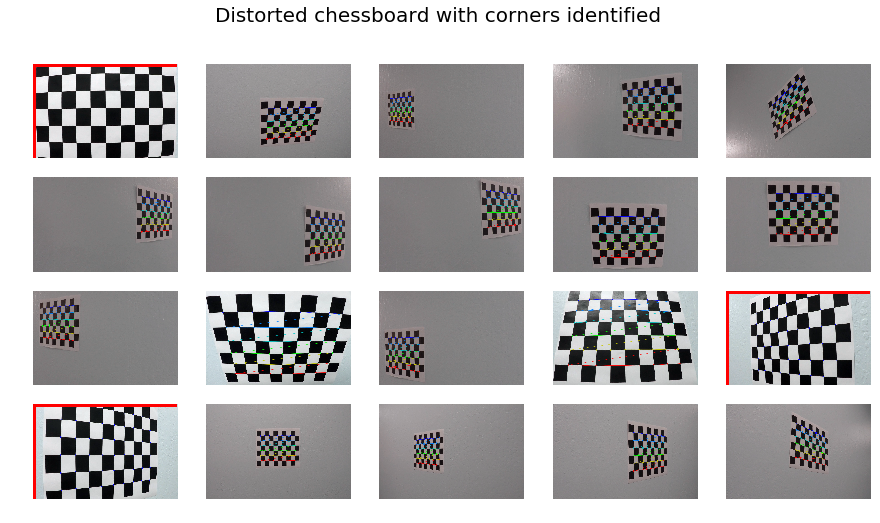

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
%matplotlib inline

# Read in and make a list of calibration images
path = 'camera_cal/'
images = glob.glob(path + 'calibration*.jpg')

# Array to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points
objp = np.zeros((9*6, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Configure plot
fig = plt.figure(facecolor="white")
fig.set_size_inches(15, 8)

for i in range(len(images)):
    # Read in each image
    img = cv2.imread(images[i])
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

    # Draw and display the corners
    ax=fig.add_subplot(4,5,i+1, aspect='equal'); 
    try:
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    except:
        pass
    ax.imshow(img);
    
    if ret != True:
        ax.axhline(linewidth=5, color="r")
        ax.axvline(linewidth=5, color="r")
    
    ax.axis('off');
    ax.axis('tight');
    
plt.suptitle('Distorted chessboard with corners identified', fontsize = 20);

Observation: For the images marked in red, it was not possible to identify the corners of the chessboard.

## Chessboard undistorted

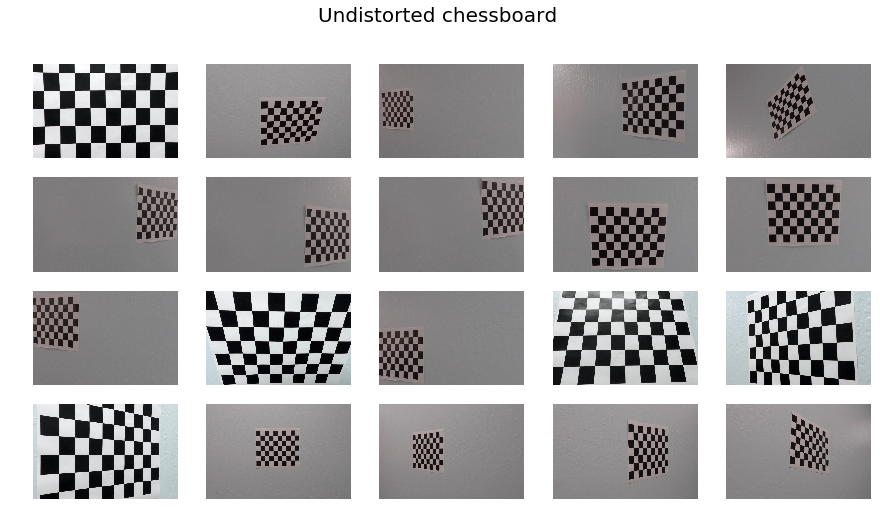

In [2]:
# Correction for distortion
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

# Function to undistort a given
def undistort_image(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

# Configure plot
fig = plt.figure(facecolor="white")
fig.set_size_inches(15, 8)

for i in range(len(images)):
    img = cv2.imread(images[i])
    
    undist = undistort_image(img)
    
    ax=fig.add_subplot(4,5,i+1, aspect='equal'); 
    ax.imshow(undist);
    ax.axis('off');
    ax.axis('tight');
    
plt.suptitle('Undistorted chessboard', fontsize = 20);

## Example images undistorted

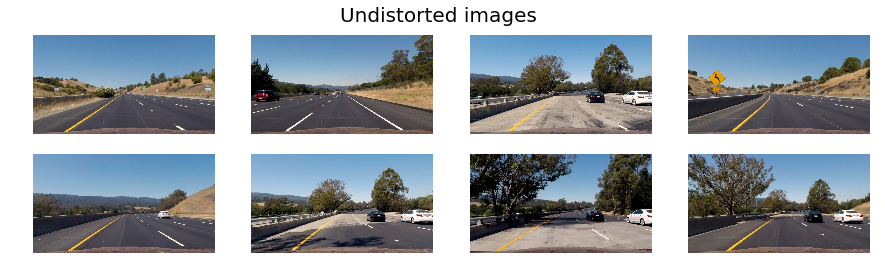

In [3]:
import os

path = "test_images//"
image_names = os.listdir(path)

# Configure plot
fig = plt.figure(facecolor="white")
fig.set_size_inches(15, 4)

for i in range(len(image_names)):
    img = cv2.imread(path + image_names[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    undist = undistort_image(img)
    
    ax=fig.add_subplot(2,4,i+1, aspect='equal'); 
    ax.imshow(undist);
    ax.axis('off');
    ax.axis('tight');
    
plt.suptitle('Undistorted images', fontsize = 20);

## Plot image

In [4]:
def plot_images(img1, img2, title1, title2, colormap):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(img2, cmap=colormap)
    ax2.set_title(title2, fontsize=30)
    ax1.axis('off');
    ax2.axis('off');

## Bird's-eye view

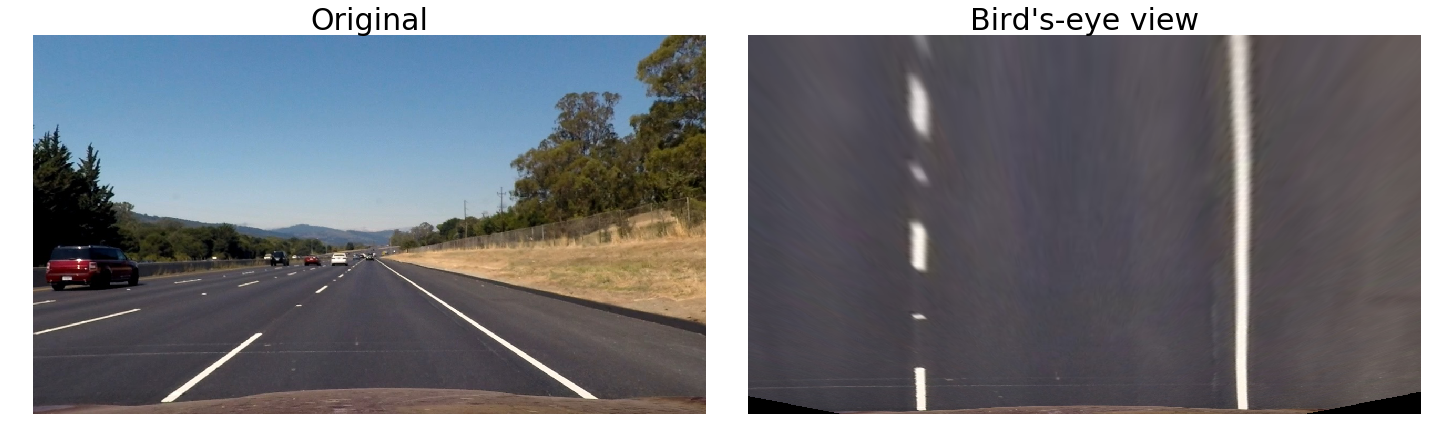

In [5]:
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

# Parameters
p1x = 545
p2x = 742
p3x = 1602
p4x = -261
pay = 450
pby = 720

# Perspective transfor function
def warp(img, p1x, p2x, p3x, p4x, pay, pby):
    
    img_size = (img.shape[1], img.shape[0])
    
    # Source coordinates
    src = np.float32([[p1x, pay], [p2x, pay], [p3x, pby], [p4x, pby]])     
    
    # Desired coordinates
    dst = np.float32([[0, 0], [img_size[0], 0], [img_size[0], img_size[1]], [0, img_size[1]]])  
    
    # Perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, src

# Test and choose parameters
def print_image(p1x, p2x, p3x, p4x, pay, pby):
    img = cv2.imread(path + image_names[1])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    # Undistort image
    img = undistort_image(img)
    
    # Transform
    img_warp, src = warp(img, p1x, p2x, p3x, p4x, pay, pby)

    # Plot
    plot_images(img, img_warp, 'Original', "Bird's-eye view", 'jet')

interact(print_image, p1x=widgets.IntSlider(min=300,max=800,step=1,value=545),
                      p2x=widgets.IntSlider(min=400,max=1000,step=1,value=742),
                      p3x=widgets.IntSlider(min=1300,max=2000,step=1,value=1602),
                      p4x=widgets.IntSlider(min=-500,max=0,step=1,value=-261),
                      pay=widgets.IntSlider(min=200,max=700,step=1,value=450),
                      pby=widgets.IntSlider(min=300,max=1000,step=1,value=720),);

## Gradient Threshold

### Sobel threshold

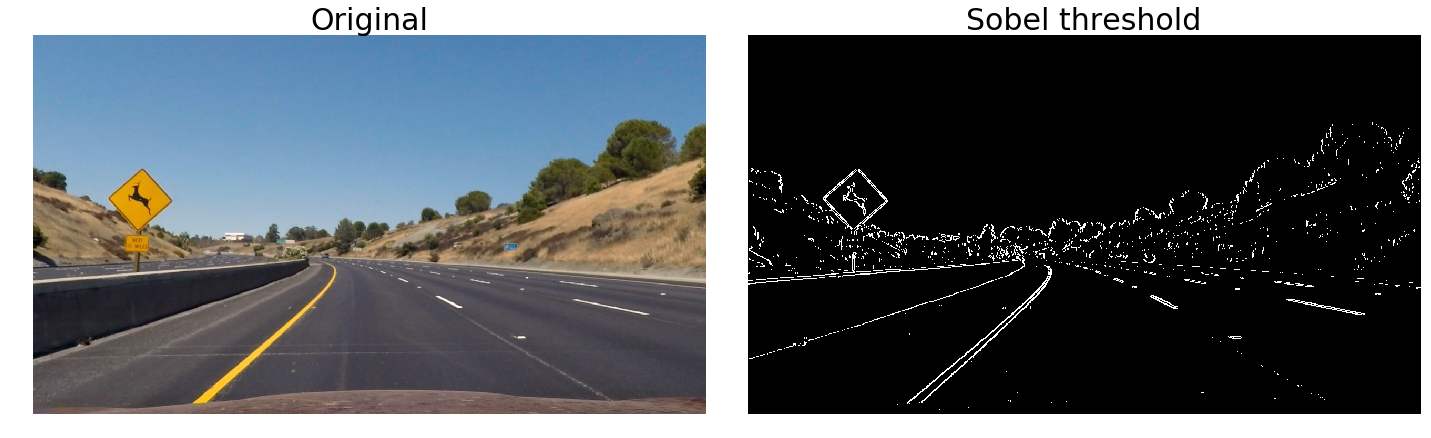

In [31]:
# Parameters
gradx_min = 40
gradx_max = 160
grady_min = 96
grady_max = 255

# Absolute sobel threshold
def sobel_threshold(img, orient, thresh_min, thresh_max):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

# Test and choose parameters
def plot_sobel_threshold(gradx_min, gradx_max, grady_min, grady_max):
    img = cv2.imread(path + image_names[3])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    # Undistort image
    img = undistort_image(img)
    
    # Transform
    gradx = sobel_threshold(img, orient='x', thresh_min=gradx_min, thresh_max=gradx_max)
    grady = sobel_threshold(img, orient='y', thresh_min=grady_min, thresh_max=grady_max)

    # Combine
    combined = gradx | grady

    # Plot
    plot_images(img, combined, 'Original', "Sobel threshold", 'gray')

interact(plot_sobel_threshold, gradx_min=widgets.IntSlider(min=0,max=255,step=1,value=gradx_min),
                                   gradx_max=widgets.IntSlider(min=0,max=255,step=1,value=gradx_max),
                                   grady_min=widgets.IntSlider(min=0,max=255,step=1,value=grady_min),
                                   grady_max=widgets.IntSlider(min=0,max=255,step=1,value=grady_max));

### Direction threshold

In [7]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobely = np.abs(sobely)
    abs_sobelx = np.abs(sobelx)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    graddir = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(graddir)
    binary_output[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1
    return binary_output

### Magnitude threshold

In [8]:
def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255.0
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

### Color Threshold

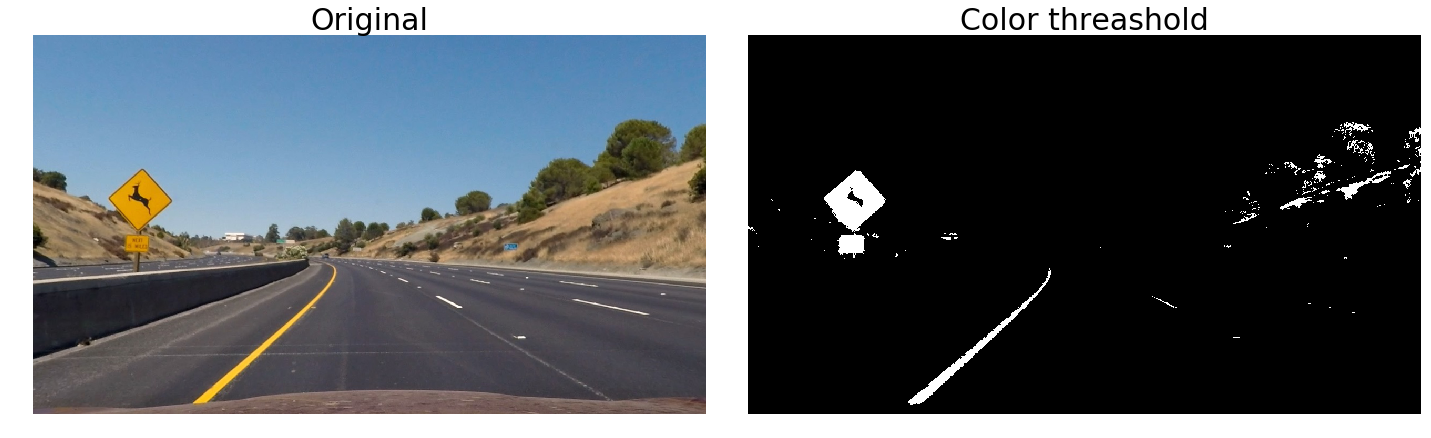

In [12]:
# Parameters
s_min = 120
s_max = 255
l_min = 40
l_max = 255

def color_threshold(img, s_thresh=(s_min, s_max), l_thresh=(l_min, l_max)):

    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    binary = np.zeros_like(s_channel)
    binary[((l_binary == 1) & (s_binary == 1))] = 1
    binary = np.array(binary).astype('uint8')
    
    return  binary

def plot_color_threshold(s_min, s_max, l_min, l_max):
    img = cv2.imread(path + image_names[3])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    # Undistort image
    img = undistort_image(img)

    # Color threashold
    color = color_threshold(img, s_thresh=(s_min, s_max), l_thresh=(l_min, l_max))

    # Plot
    plot_images(img, color, 'Original', "Color threashold", 'gray')

interact(plot_color_threshold, s_min=widgets.IntSlider(min=0,max=255,step=1,value=s_min),
                             s_max=widgets.IntSlider(min=0,max=255,step=1,value=s_max),
                             l_min=widgets.IntSlider(min=0,max=255,step=1,value=l_min),
                             l_max=widgets.IntSlider(min=0,max=255,step=1,value=l_max));

## Define pipeline

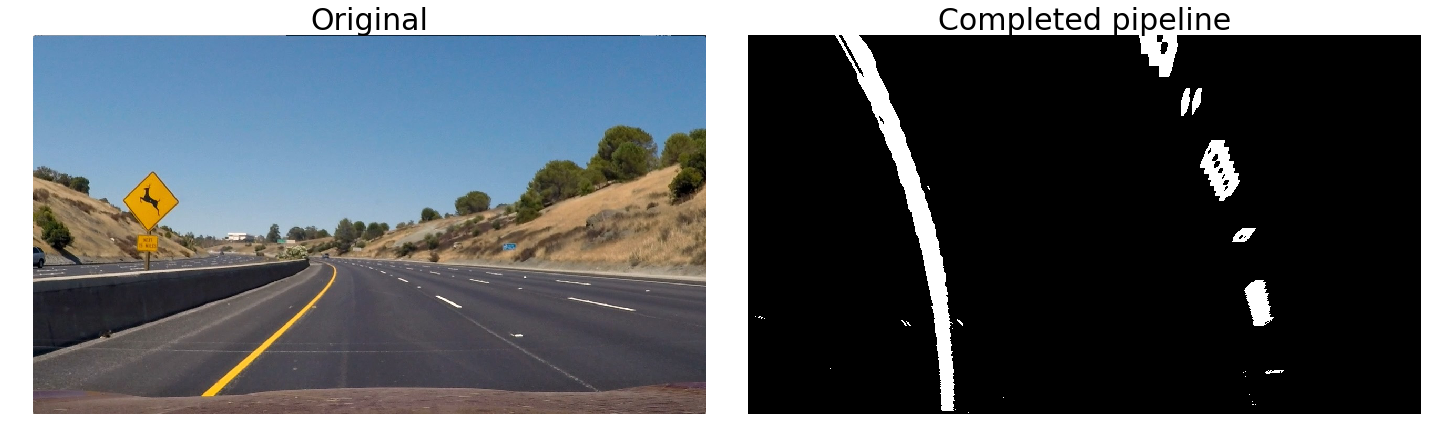

In [32]:
# Read in an image
img = cv2.imread(path + image_names[3])
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

def pipeline(img):    
    # Undistort image
    img = undistort_image(img)

    # Color threashold
    color = color_threshold(img)
    
    # Sobel threashold
    gradx = sobel_threshold(img, orient='x', thresh_min=gradx_min, thresh_max=gradx_max)
    grady = sobel_threshold(img, orient='y', thresh_min=grady_min, thresh_max=grady_max)
    
    # Combine
    combined = color | gradx | grady
    
    # Warp image
    img_warp, _ = warp(combined, p1x, p2x, p3x, p4x, pay, pby)

    return img_warp
    
# Plot
plot_images(img, pipeline(img), 'Original', "Completed pipeline", 'gray')